In [1]:
import pandas as pd
import numpy as np
import duckdb
import re
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# import minmaxscaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
con = duckdb.connect()
df = con.sql("""
    select
        lower(brand) as brand
        , lower(model) as model
        , replace(replace(replace(lower(version), '[', ''), ']', ''), ', ', ' ') as version
        -- , replace(replace(description, '[', ''), ']', '') as description
        , kms
        , lower(energy) as energy
        , lower(gear) as gear
        , year registry_year
        , price
        , dateIntegration
    from read_parquet('../../db.parquet')
    order by dateIntegration;  
""").fetchdf()

In [3]:
df

,brand,model,version,kms,energy,gear,registry_year,price,dateIntegration
0,volkswagen,t-roc,t-roc 2.0 tdi 150 start/stop dsg7 r-line,20400,diesel,automatique,2021,35990,2023-03-07
1,citroen,grand c4 picasso,1.2 puretech 130cv bvm6 7pl feel + sieges chau...,84300,essence,manuelle,2019,21310,2023-03-07
2,citroen,c4,bluehdi 110 s&s bvm6 live,2400,diesel,manuelle,2021,20500,2023-03-07
3,citroen,c1,c1 vti 72 s&s feel,5000,essence,manuelle,2021,12890,2023-03-07
4,citroen,c3,1.2 puretech 83ch s&s shine 123g,100,essence,manuelle,2021,17490,2023-03-07
...,...,...,...,...,...,...,...,...,...
3981099,volkswagen,taigo,1.0 tsi 110ch r-line,10,essence,automatique,2023,29970,2023-04-16
3981100,volkswagen,polo,1.2 tdi 75,113000,diesel,manuelle,2011,7990,2023-04-16
3981101,renault,zoe,(2) r110 zen,24300,électrique,automatique,2020,15290,2023-04-16
3981102,volkswagen,polo,v 1.4 tdi 90 bluemotion technology serie speci...,151452,diesel,manuelle,2015,8990,2023-04-16


In [4]:
df = df[(df.brand == 'peugeot')].drop_duplicates(subset=['brand', 'model', 'version', 'kms', 'energy', 'gear'], keep='last')

In [5]:
def clean_version(x):
    stopword = ['cv', ' ', '', '5p', '-', '.', '|', '+', '+options', 'options', 'option', 'opt', 'brand', 'model', 'energy', 'gear', 'kms', 'version', 's&s']
    version = x.lower().split(' ')
    version = [word.replace('cv', '').replace('.', '') for word in version if word not in stopword]
    for v in version:
        if re.search(r'\d', v):
            version[version.index(v)] = v.replace('ch', '')
    return ' '.join(version)

df.version = df.version.apply(clean_version)
# df.description = df.description.apply(clean_version)
# df.description = df.description.apply(lambda x: ' '.join(x.split(',')[5:15]))
df.brand = df.brand.apply(lambda x: x.lower())
df.model = df.model.apply(lambda x: x.lower())
df.dateIntegration = df.dateIntegration.apply(lambda x: x.strftime('%Y-%m-%d'))
df['title'] = df.brand + ' ' + df.model + ' ' + df.version + ' ' + df.energy + ' ' + df.gear + ' ' + df.dateIntegration
df = df.drop(columns=['brand', 'model', 'version', 'energy', 'gear', 'dateIntegration'])
df.title = df.title.apply(lambda x: ' '.join(sorted(set(x.split(' ')))))
df.drop_duplicates(subset=['title', 'kms', 'registry_year'], inplace=True)
df.shape

(30084, 4)

In [6]:
df

,kms,registry_year,price,title
45655,18178,2020,34990,2023-03-07 225 508 automatique e-eat8 gt hybri...
45689,8864,2020,18990,100 2023-03-07 208 allure bvm6 essence manuell...
45732,30188,2020,26980,12 130 2023-03-07 3008 6 allure automatique ea...
45765,47400,2021,19999,130 15 2023-03-07 308 active automatique blueh...
45779,21703,2019,11690,108 2023-03-07 72 collection essence manuelle ...
...,...,...,...,...
3980534,10,2023,37990,130 2023-04-16 408 allure automatique ch eat8 ...
3980538,4696,2022,29900,12 130 2023-04-16 308 allure automatique eat8 ...
3980774,27286,2021,21499,130 15 2023-04-16 308 allure bluehdi diesel ma...
3981008,79751,2018,20980,12 130 2023-04-16 3008 allure bvm6 essence man...


In [7]:
df1 = df.copy()

In [8]:
vectorizer = CountVectorizer()
X_text = vectorizer.fit_transform(df1.title)
# X_desc = vectorizer.fit_transform(df.description)
# X_text = np.concatenate((X_text.toarray(), X_desc.toarray()), axis=1)
# Sélectionner les colonnes numériques
X_num = df1.drop(columns=['title', 'price']).values
# sc = StandardScaler()
sc = MinMaxScaler()
X = sc.fit_transform(X_num)
# Concaténer les deux matrices
X = np.concatenate((X_text.toarray(), X_num), axis=1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, df.price, test_size=0.2, random_state=42)

In [10]:
# XGBoost
# Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
xgb = XGBRegressor(colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=1000)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('XGBoost')
print('R2: ', r2_score(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

XGBoost
R2:  0.9682249017984602
MAE:  1174.0566292030978
RMSE:  1575.7639450968636


In [11]:
df['prediction'] = xgb.predict(X)
df.prediction = df.prediction.apply(lambda x: round(x, -2))
df['error'] = df.price - df.prediction
df['error_percent'] = df.error / df.price * 100

In [12]:
df

,kms,registry_year,price,title,prediction,error,error_percent
45655,18178,2020,34990,2023-03-07 225 508 automatique e-eat8 gt hybri...,37100.0,-2110.0,-6.030294
45689,8864,2020,18990,100 2023-03-07 208 allure bvm6 essence manuell...,20500.0,-1510.0,-7.951553
45732,30188,2020,26980,12 130 2023-03-07 3008 6 allure automatique ea...,28400.0,-1420.0,-5.263158
45765,47400,2021,19999,130 15 2023-03-07 308 active automatique blueh...,22800.0,-2801.0,-14.005700
45779,21703,2019,11690,108 2023-03-07 72 collection essence manuelle ...,12400.0,-710.0,-6.073567
...,...,...,...,...,...,...,...
3980534,10,2023,37990,130 2023-04-16 408 allure automatique ch eat8 ...,38000.0,-10.0,-0.026323
3980538,4696,2022,29900,12 130 2023-04-16 308 allure automatique eat8 ...,30300.0,-400.0,-1.337793
3980774,27286,2021,21499,130 15 2023-04-16 308 allure bluehdi diesel ma...,24500.0,-3001.0,-13.958789
3981008,79751,2018,20980,12 130 2023-04-16 3008 allure bvm6 essence man...,21600.0,-620.0,-2.955195


In [13]:
from matplotlib import pyplot as plt
import seaborn as sns

C:\Users\j.nataf\AppData\Local\Temp\ipykernel_7152\549451625.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.error, bins=100)


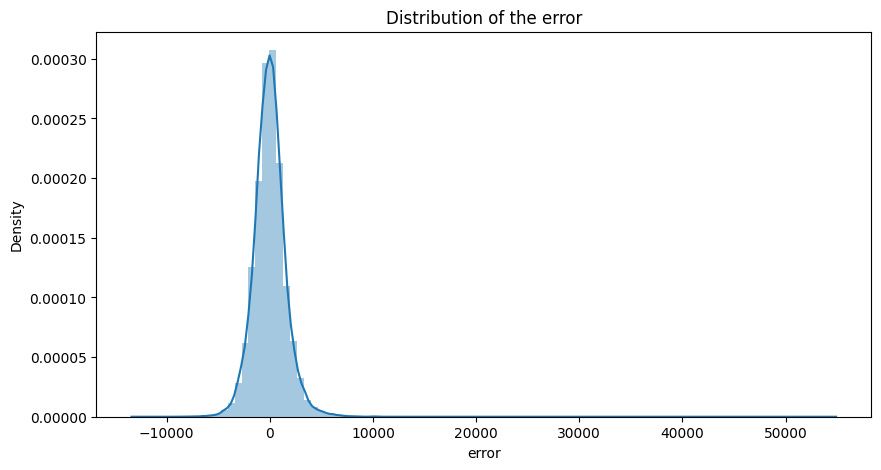

In [14]:
# Bar plot repartition error abs
plt.figure(figsize=(10, 5))
sns.distplot(df.error, bins=100)
plt.title('Distribution of the error')
plt.show()

In [15]:
df.error.describe()

count    30084.000000
mean        -2.599521
std       1568.353936
min     -12800.000000
25%       -910.000000
50%        -10.000000
75%        889.000000
max      54300.000000
Name: error, dtype: float64

In [16]:
df['error_abs'] = df.error.apply(lambda x: abs(x))


In [17]:
df[df.error_abs <2000].error_abs.describe()

count    25147.000000
mean       794.663896
std        530.429993
min          0.000000
25%        320.000000
50%        710.000000
75%       1190.000000
max       1999.000000
Name: error_abs, dtype: float64

C:\Users\j.nataf\AppData\Local\Temp\ipykernel_7152\602821130.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.error_abs, bins=100)


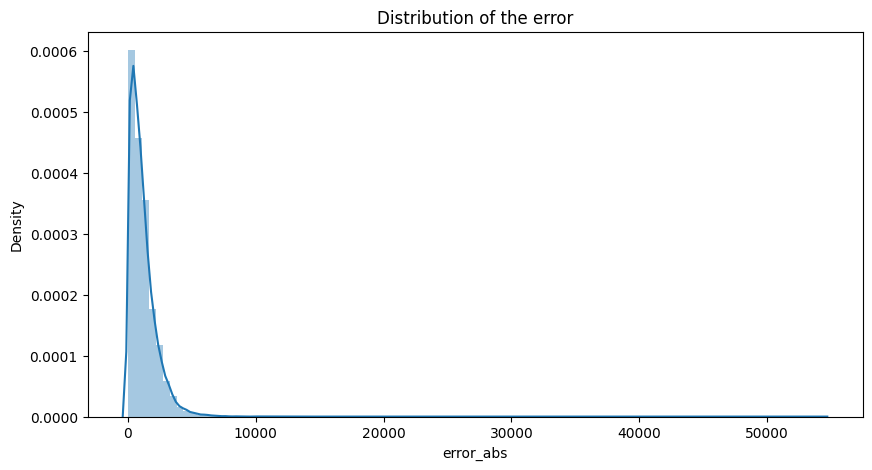

In [18]:
# Bar plot repartition error abs
plt.figure(figsize=(10, 5))
sns.distplot(df.error_abs, bins=100)
plt.title('Distribution of the error')
plt.show()

In [35]:
# test to predict price
car = {
    'brand': 'peugeot',
    'model': '208',
    'version': '1.2 PureTech 100 S&S BVM5 active essence manuelle',
    'dateIntegration': '2023-04-16',
    'kms': 46000,
    'registry_year': 2020,
}

def predict_price(car):
    car = pd.DataFrame(car, index=[0])
    car.version = car.version.apply(clean_version)
    car.brand = car.brand.apply(lambda x: x.lower())
    car.model = car.model.apply(lambda x: x.lower())
    car['title'] = car.brand + ' ' + car.model + ' ' + car.version + ' ' + car.dateIntegration
    car = car.drop(columns=['brand', 'model', 'version', 'dateIntegration'])
    car.title = car.title.apply(lambda x: ' '.join(sorted(set(x.split(' ')))))
    X_text = vectorizer.transform(car.title)
    X_num = car.drop(columns=['title']).values
    sc = StandardScaler()
    X = sc.fit_transform(X_num)
    X = np.concatenate((X_text.toarray(), X_num), axis=1)
    return xgb.predict(X)

print("r2_score : ", r2_score(y_test, y_pred))
print('RMSE : ', np.sqrt(mean_squared_error(y_test, y_pred)))
# Moyenne des erreurs et ecart type
print('Moyenne des erreurs : ', df.error.mean())
print('Ecart type des erreurs : ', df.error.std())
print(predict_price(car))
df[df.title.str.contains('208') & (df.registry_year == 2020) 
    & (df.kms < 60000) & (df.kms > 35000)
    & df.title.str.contains('active') & df.title.str.contains('100') & df.title.str.contains('essence')
    & df.title.str.contains('manuelle')
].sort_values(by='price')


r2_score :  0.9682249017984602
RMSE :  1575.7639450968636
Moyenne des erreurs :  -2.5995213402473074
Ecart type des erreurs :  1568.353935982422
[15960.32]


,kms,registry_year,price,title,prediction,error,error_percent,error_abs
3931208,51171,2020,16490,100 12 2023-04-16 208 active bvm6 essence manu...,17100.0,-610.0,-3.699212,610.0
3025659,40172,2020,16890,100 2023-04-07 208 active bvm6 essence manuell...,17200.0,-310.0,-1.835406,310.0
3942518,57518,2020,16990,100 12 2023-04-16 208 active essence manuelle ...,16400.0,590.0,3.472631,590.0
2804094,36201,2020,17380,100 12 2023-04-04 208 active essence manuelle ...,17200.0,180.0,1.035673,180.0
565513,35572,2020,17990,100 12 2023-03-12 208 active essence manuelle ...,17400.0,590.0,3.279600,590.0
3843944,42506,2020,17990,100 12 2023-04-15 208 active business essence ...,16900.0,1090.0,6.058922,1090.0
939140,42300,2020,18350,100 12 2023-03-16 208 active bvm6 chauffants e...,18300.0,50.0,0.272480,50.0
3940440,52265,2020,18900,100 2023-04-16 208 active bvm6 essence manuell...,16900.0,2000.0,10.582011,2000.0
3937176,41538,2020,18990,100 12 2023-04-16 208 active essence manuelle ...,17100.0,1890.0,9.952607,1890.0
3933462,41580,2020,19490,100 12 2023-04-16 208 active essence manuelle ...,17100.0,2390.0,12.262699,2390.0


In [20]:
df[df.title.str.contains('qashqai') & (df.registry_year == 2017) & (df.kms < 80000) & df.title.str.contains('tekna') & df.title.str.contains('130') & df.title.str.contains('2023-04-16')].values

array([], shape=(0, 8), dtype=object)

In [26]:
# Export the model to a pickle file
import pickle
pickle.dump(xgb, open('model.pkl', 'wb'))
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))
pickle.dump(sc, open('scaler.pkl', 'wb'))

In [22]:
# Load the model from the file
pkl_model = pickle.load(open('model.pkl', 'rb'))
plk_vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))
plk_sc = pickle.load(open('scaler.pkl', 'rb'))

# Use the loaded model to make predictions
print("r2_score : ", r2_score(y_test, y_pred))
print('RMSE : ', np.sqrt(mean_squared_error(y_test, y_pred)))
car = {
    'brand': 'Nissan',
    'model': 'Qashqai',
    'version': '1.7 dci 130 tekna',
    'kms': 60000,
    'registry_year': 2017,
}
def predict_price_with_model(car):
    car = pd.DataFrame(car, index=[0])
    car.version = car.version.apply(clean_version)
    car.brand = car.brand.apply(lambda x: x.lower())
    car.model = car.model.apply(lambda x: x.lower())
    car['title'] = car.brand + ' ' + car.model + ' ' + car.version
    car = car.drop(columns=['brand', 'model', 'version'])
    car.title = car.title.apply(lambda x: ' '.join(sorted(set(x.split(' ')))))
    X_text = plk_vectorizer.transform(car.title)
    X_num = car.drop(columns=['title']).values
    X = plk_sc.fit_transform(X_num)
    X = np.concatenate((X_text.toarray(), X_num), axis=1)
    return pkl_model.predict(X)

print(predict_price_with_model(car))
df[df.title.str.contains('nissan|qashqai')]


r2_score :  0.9682249017984602
RMSE :  1575.7639450968636
[16891.768]


,kms,registry_year,price,title,prediction,error,error_percent,error_abs
